In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from fcmeans import FCM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv('respiratory_clean.csv')
df = data.copy()

In [22]:
df.head(2)

,sex,age,duration,cough,night_fever,catarrh,cold,tenderness,headache,black_stool,...,vaginal_discharge,vaginal_itching,stooling,running_nose,club_pain,bleeding_from_the_nose,unable_to_speak,mouth_breathing,sleep_apneas,symptoms
0,M,13,7,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,MALARIA
1,M,13,7,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,URTI


In [23]:
# Preprocess the data
def preprocess_data(df):
    # Encode categorical variables
    if 'sex' in df.columns:
        df['sex'] = LabelEncoder().fit_transform(df['sex'])

    # Drop non-numeric columns
    if 'symptoms' in df.columns:
        df = df.drop(columns=['symptoms'])

    # Handle missing values
    df = df.dropna()

    # Standardize the data
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    return scaled_data, scaler, numeric_columns

data_scaled, scaler, numeric_columns = preprocess_data(df)

In [24]:
# Fuzzy C-Means Clustering
def apply_fcm(data, n_clusters=2):
    fcm = FCM(n_clusters=n_clusters, random_state=42)
    fcm.fit(data)
    return fcm

fcm = apply_fcm(data_scaled)

In [25]:
# Evaluation Metrics
def evaluate_fcm(fcm, data):
    # Partition Coefficient (PC)
    pc = np.mean(np.sum(fcm.u ** 2, axis=1))
    
    # Partition Entropy (PE)
    pe = -np.mean(np.sum(fcm.u * np.log(fcm.u + 1e-10), axis=1))
    
    return pc, pe

pc, pe = evaluate_fcm(fcm, data_scaled)
print(f"Partition Coefficient (PC): {pc:.4f}")
print(f"Partition Entropy (PE): {pe:.4f}")

Partition Coefficient (PC): 0.5000
Partition Entropy (PE): 0.6931


In [26]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)
centers_2d = pca.transform(fcm.centers)

In [27]:
# Assign clusters
labels = fcm.u.argmax(axis=1)

In [28]:
# Cluster Statistics
def summarize_clusters(labels, membership_scores):
    summary = pd.DataFrame({
        "Cluster": labels,
        "Max Membership Score": membership_scores.max(axis=1)
    }).groupby("Cluster").agg(
        Samples=('Cluster', 'count'),
        Avg_Membership=('Max Membership Score', 'mean')
    )
    return summary

cluster_summary = summarize_clusters(labels, fcm.u)
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
         Samples  Avg_Membership
Cluster                         
0            149        0.500001
1            156        0.500000


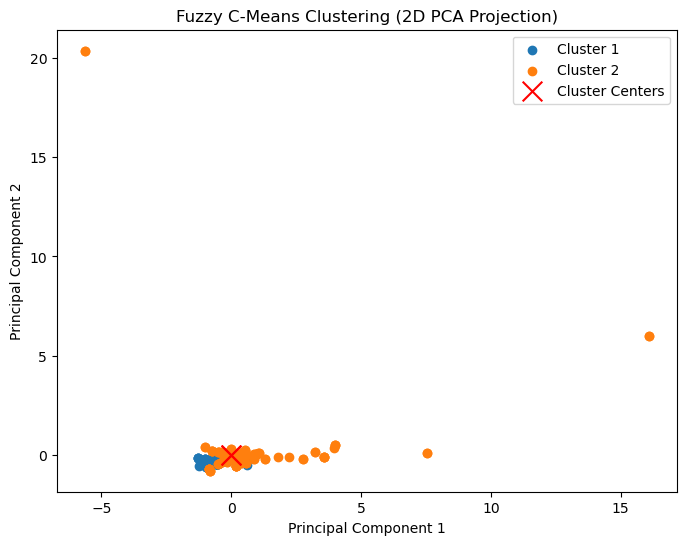

In [30]:
# Plot clusters
def plot_clusters(data_2d, centers_2d, labels, n_clusters=2):
    plt.figure(figsize=(8, 6))
    for cluster in range(n_clusters):
        plt.scatter(data_2d[labels == cluster, 0], data_2d[labels == cluster, 1], label=f"Cluster {cluster+1}")
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='x', s=200, label='Cluster Centers')
    plt.title("Fuzzy C-Means Clustering (2D PCA Projection)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

plot_clusters(data_2d, centers_2d, labels)

In [32]:
import pickle
# Save FCM model
with open("fcm_model.pkl", "wb") as f:
    pickle.dump(fcm, f)

## Preidcting New Data

In [33]:
# Predict Cluster for New Data
def predict_cluster(input_data, scaler, fcm):
    try:
        input_scaled = scaler.transform(np.array(input_data).reshape(1, -1))
        membership = fcm.predict(input_scaled)
        predicted_cluster = np.argmax(membership)
        return predicted_cluster, membership
    except Exception as e:
        return None, str(e)

In [41]:
# Example Prediction
new_data_point = (0,40,10,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1)
cluster, membership = predict_cluster(new_data_point, scaler, fcm)
if cluster is not None:
    # Check if membership is a 1D array or a single value
    if isinstance(membership, np.ndarray) and membership.ndim == 2:
        # Flatten the array to make sure it's iterable
        membership_percentages = [f"{score * 100:.2f}%" for score in membership[0]]
    else:
        # If it's a single value (cluster assignment), no need to format percentages
        membership_percentages = [f"Cluster {cluster + 1}: 100.00%"]

    # Create a more readable output for the cluster and membership scores
    print(f"\nThe new data point belongs to Cluster {cluster + 1}.")
    print("\nMembership Scores:")
    
    # Print each membership score with its corresponding cluster
    for i, score in enumerate(membership_percentages):
        print(f"{score}")
else:
    print(f"Error in prediction: {membership}")


The new data point belongs to Cluster 1.

Membership Scores:
Cluster 1: 100.00%


C:\Users\ICE\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
